In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray

import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
f = netCDF4.Dataset("ghcn-dsg.nc")

## Station distribution

In [3]:
x_points = f["lon"][...]
y_points = f["lat"][...]
x_grid, y_grid = np.meshgrid(np.arange(-180, 180, 5), np.arange(-90, 90, 5))

# Count the number of points in each cell
hist, x_edges, y_edges = np.histogram2d(x_points, y_points, bins=[x_grid[0], y_grid[:, 0]])

# The 'hist' variable now contains the counts of points in each cell
print(hist)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


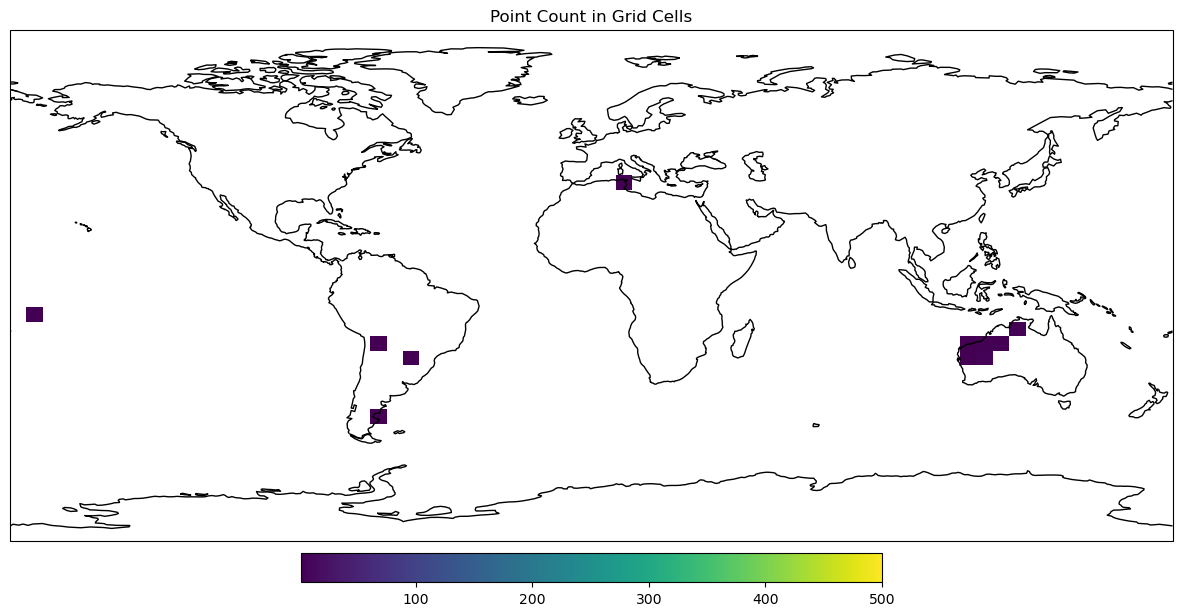

In [4]:
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.get_cmap('viridis')
cmap.set_under('white')

# use hexbin?
cax = ax.imshow(hist.T, extent=(-180.0, 180.0, -90.0, 90.0), origin='lower', cmap=cmap, aspect='auto', vmin=1, vmax=500)
ax.coastlines()
ax.set_extent((-180.0, 180.0, -90.0, 90.0))

cbar = plt.colorbar(cax, orientation="horizontal", shrink=0.5, pad=0.02)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Point Count in Grid Cells')

plt.show()

## Particular station data

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 7.8000e+01,
        3.6750e+03, 1.3349e+04, 3.7350e+03, 1.0000e+01, 1.0000e+00]),
 array([-204.        , -143.19999695,  -82.40000153,  -21.60000038,
          39.20000076,  100.        ,  160.80000305,  221.6000061 ,
         282.3999939 ,  343.20001221,  404.        ]),
 <BarContainer object of 10 artists>)

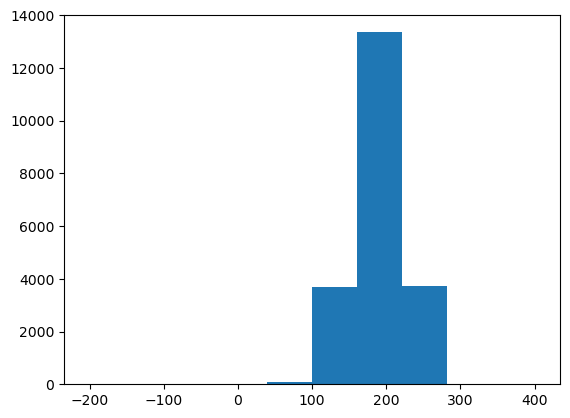

In [5]:
stations = f["station"][...].view('S11').ravel().tolist()

st = b"AR000087007"
i = stations.index(st)

frm = f["rowSize"][0:i].sum()
to = f["rowSize"][0:i+1].sum()

plt.hist(f["tasmax"][frm:to])

## Pandas

In [6]:
df = pd.DataFrame({
    "station": [st.decode("ascii") for st in stations for _ in range(f["rowSize"][stations.index(st)])],
    "time": list(f["time"][...]),
    "tasmax": f["tasmax"][...].filled(np.nan) * f["tasmax"].getncattr("scale_factor"),
    "tasmin": f["tasmin"][...].filled(np.nan) * f["tasmin"].getncattr("scale_factor"),
})

In [7]:
df

,station,time,tasmax,tasmin
0,ASN00006076,114199.0,NaN,NaN
1,ASN00006076,114200.0,NaN,NaN
2,ASN00006076,114201.0,NaN,NaN
3,ASN00006076,114202.0,NaN,NaN
4,ASN00006076,114203.0,NaN,NaN
...,...,...,...,...
332513,AQC00914149,132821.0,NaN,NaN
332514,AQC00914149,132822.0,NaN,NaN
332515,AQC00914149,132823.0,NaN,NaN
332516,AQC00914149,132824.0,NaN,NaN


In [8]:
df.groupby("station").max()

,time,tasmax,tasmin
station,,,
AGM00060559,155000.0,49.600002,35.799999
AQC00914149,132825.0,NaN,NaN
AR000000003,146249.0,NaN,NaN
AR000087007,155000.0,40.400002,63.200001
ARM00087896,155000.0,40.100002,21.200001
ASN00002003,144239.0,NaN,NaN
ASN00002064,154862.0,45.500000,33.200001
ASN00003049,119553.0,NaN,NaN
ASN00004016,154862.0,NaN,NaN


<Axes: >

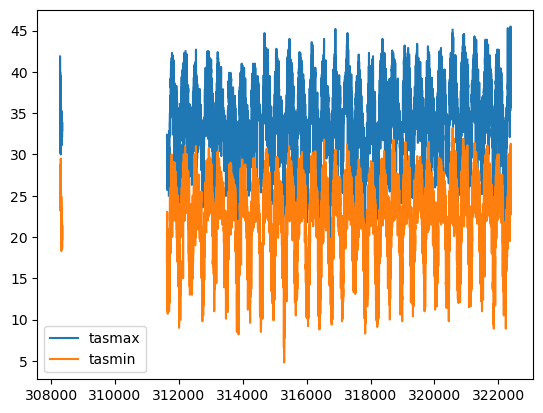

In [9]:
df[df["station"] == "ASN00002064"][["tasmax", "tasmin"]].plot()

## xarray

In [10]:
df = pd.DataFrame({
    "station": [st.decode("ascii") for st in stations for _ in range(f["rowSize"][stations.index(st)])],
    "time": cftime.num2pydate(f["time"][...].data, f["time"].getncattr("units"), f["time"].getncattr("calendar")),
    "tasmax": f["tasmax"][...].filled(np.nan) * f["tasmax"].getncattr("scale_factor"),
    "tasmin": f["tasmin"][...].filled(np.nan) * f["tasmin"].getncattr("scale_factor"),
})

In [11]:
ds = xarray.Dataset.from_dataframe(df.set_index(["station", "time"]))
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (station: 20, time: 43861)
Coordinates:
  * station  (station) object 160B 'AGM00060559' 'AQC00914149' ... 'ASN00007093'
  * time     (time) datetime64[ns] 351kB 1750-03-01 1750-03-02 ... 2024-05-17
Data variables:
    tasmax   (station, time) float32 4MB nan nan nan nan nan ... nan nan nan nan
    tasmin   (station, time) float32 4MB nan nan nan nan nan ... nan nan nan nan

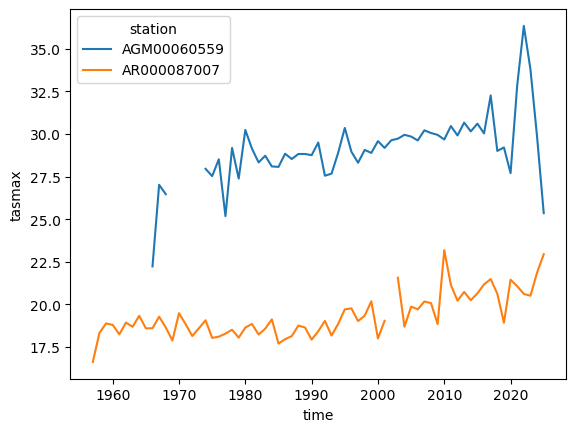

In [12]:
ds["tasmax"].sel(station=["AGM00060559", "AR000087007"], time=slice("19500101", None)).resample(time="YE").mean().plot.line(x="time")

## Load country info

In [13]:
import urllib.request

countries_url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"

with urllib.request.urlopen(countries_url) as fin:
    df = pd.DataFrame(
        [line.rstrip("\n").split(" ", 1) for line in fin.read().decode("utf-8").split("\n")],
        columns=["fips", "name"]).dropna()

In [14]:
df

,fips,name
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
...,...,...
214,WI,Western Sahara
215,WQ,Wake Island [United States]
216,WZ,Swaziland
217,ZA,Zambia
